# Spike Gadgets Ephys and Video Syncing

In [1]:
import os
import re
import sys
from collections import defaultdict
import random
from random import randrange
import glob
import warnings

In [2]:
import numpy as np
import pandas as pd
# import cv2
from IPython.display import Video
import matplotlib.pyplot as plt

In [3]:
# setting path
sys.path.append('../../../src')

In [4]:
%matplotlib inline

In [5]:
import spikeinterface

In [6]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/tmp/ipykernel_3244569/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [7]:
import spikeinterface.core

In [8]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [9]:
import spikeinterface.full as si

# Reading in the Timestamp Information

In [10]:
tone_label_file_ending = "tone_label_df"

In [11]:
tone_label_path = glob.glob("./proc/*{}.csv*".format(tone_label_file_ending))[0]

In [12]:
tone_label_path

'./proc/20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3_tone_label_df.csv'

In [13]:
recording_name = os.path.splitext(os.path.basename(tone_label_path))[0].strip(tone_label_file_ending)

In [14]:
recording_name

'20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3'

In [15]:
tone_time_stamps_df = pd.read_csv(tone_label_path, index_col=0)

In [16]:
tone_time_stamps_df

,tone_time_stamp,tone_category,tone_clock_time_omission,tone_clock_time_comp
0,1408048,rewarded,60.40240,-1269.52745
1,3008051,rewarded,140.40255,-1189.52730
2,4808043,rewarded,230.40215,-1099.52770
3,6408042,omission,310.40210,-1019.52775
4,7908040,rewarded,385.40200,-944.52785
5,9908037,rewarded,485.40185,-844.52800
6,11808035,rewarded,580.40175,-749.52810
7,13608031,rewarded,670.40155,-659.52830
8,15208032,omission,750.40160,-579.52825
9,17008029,rewarded,840.40145,-489.52840


# Reading in Phy

- Which unit the spike came from

In [17]:
spike_clusters_path = glob.glob("./proc/**/phy/spike_clusters.npy", recursive=True)[0]

In [18]:
spike_clusters_path[0]

'.'

In [19]:
spike_clusters = np.load(spike_clusters_path)

In [20]:
spike_clusters[:10]

array([ 39, 170,  60,  60,  88, 183,  19,  67, 174,  20], dtype=int32)

- The classification of each unit

In [21]:
cluster_info_path = glob.glob("./proc/**/phy/cluster_info.tsv", recursive=True)[0]

In [22]:
cluster_group_df = pd.read_csv(cluster_info_path, sep="\t")

In [23]:
cluster_group_df

,cluster_id,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
0,0,427.0,0,0.0,0.0,0.263283,noise,844,0,1.0
1,2,188.0,1,0.0,20.0,1.147027,mua,3677,0,3.0
2,3,193.0,1,0.0,20.0,0.859724,noise,2756,0,4.0
3,4,871.0,2,0.0,40.0,12.211762,mua,39147,0,5.0
4,5,504.0,2,0.0,40.0,3.960782,mua,12697,0,6.0
...,...,...,...,...,...,...,...,...,...,...
93,183,932.0,29,0.0,580.0,9.470066,good,30358,0,73.0
94,187,568.0,6,0.0,120.0,0.096079,mua,308,0,19.0
95,188,568.0,6,0.0,120.0,0.664446,good,2130,0,19.0
96,197,932.0,29,0.0,580.0,0.351563,mua,1127,0,73.0


- Filtering for the good units

In [24]:
good_unit_cluster_info_df = cluster_group_df[cluster_group_df["group"] == "good"]

In [25]:
good_unit_cluster_info_df

,cluster_id,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
15,16,1147.5,6,0.0,120.0,0.864403,good,2771,0,17.0
18,20,1113.0,7,0.0,140.0,5.995296,good,19219,0,21.0
22,24,1206.0,9,0.0,180.0,5.371091,good,17218,0,25.0
35,50,1644.0,21,0.0,420.0,1.107409,good,3550,0,51.0
36,52,870.0,21,0.0,420.0,1.168551,good,3746,0,53.0
38,54,448.5,22,0.0,440.0,7.901600,good,25330,0,55.0
43,59,253.0,24,0.0,480.0,1.836116,good,5886,0,60.0
47,64,633.0,26,0.0,520.0,2.901412,good,9301,0,65.0
81,156,440.0,19,0.0,380.0,0.868770,good,2785,0,47.0
84,163,542.0,21,0.0,420.0,1.598101,good,5123,0,52.0


In [26]:
good_unit_unique_ids = good_unit_cluster_info_df["cluster_id"].values

In [27]:
good_unit_unique_ids

array([ 16,  20,  24,  50,  52,  54,  59,  64, 156, 163, 174, 182, 183,
       188])

- The times that all the spikes happened

In [28]:
spike_time_path = glob.glob("./proc/**/phy/spike_times.npy", recursive=True)[0]

In [29]:
spike_times = np.load(spike_time_path)

In [30]:
spike_times[:10]

array([[ 11],
       [ 89],
       [143],
       [178],
       [215],
       [260],
       [309],
       [344],
       [413],
       [487]])

- Getting a list of the IDs that were good from the list of unit ids for all the firings

In [31]:
good_unit_mask = np.isin(spike_clusters, good_unit_unique_ids)

In [32]:
good_unit_all_ids = spike_clusters[good_unit_mask]

In [33]:
good_unit_all_ids.shape

(172619,)

In [34]:
good_unit_all_ids[:10]

array([183, 174,  20, 183,  24, 182, 183,  54,  54,  64], dtype=int32)

- Getting the time that the good units fired

In [35]:
good_unit_times = spike_times[good_unit_mask].T[0]

In [36]:
good_unit_times.shape

(172619,)

In [37]:
good_unit_times[:10]

array([ 260,  413,  487,  821, 1190, 1588, 1640, 1701, 2087, 2467])

In [38]:
good_unit_times[-10:]

array([64108851, 64109062, 64109114, 64109909, 64110757, 64110943,
       64111416, 64112221, 64112277, 64113530])

- spike_times are indexed based on the start of the recording, not the start of the streaming
    - Last spike ends right before the end of the recording time

In [39]:
spike_times

array([[      11],
       [      89],
       [     143],
       ...,
       [64113456],
       [64113530],
       [64113594]])

In [40]:
spike_times[-1]/20000

array([3205.6797])

## Syncing the unit times with the ECU times

In [41]:
tone_time_stamps = tone_time_stamps_df["tone_time_stamp"].values

In [42]:
tone_time_stamps

array([ 1408048,  3008051,  4808043,  6408042,  7908040,  9908037,
       11808035, 13608031, 15208032, 17008029, 19008027, 20808026,
       23208023, 25008021, 27998597, 29598593, 31398591, 32998593,
       34498591, 36498588, 38398586, 40198584, 41798580, 43598581,
       45598579, 47398577, 49798572, 51598570, 53298568, 55098566,
       56998564, 59398564, 60998563])

## Seeing which tone time each unit time is closest to

- We will divide all the time up into bins of before and after each tone. Then we will see which time bin the neuron firing falls into.
    - So everything in the 0 bin would be before the first time bin. The 1 bin would be everything in between the first and second time bin. The last would be everything after last time bin.

In [43]:
good_unit_bins = np.digitize(good_unit_times, tone_time_stamps_df["tone_time_stamp"], right=True)

In [44]:
good_unit_bins.shape

(172619,)

In [45]:
good_unit_bins[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
good_unit_bins[-10:]

array([33, 33, 33, 33, 33, 33, 33, 33, 33, 33])

- Seeing if the firing time is within a 10 second interval before or 10 second after any tone

In [47]:
from collections import defaultdict

In [48]:
good_unit_bins.shape

(172619,)

In [49]:
good_unit_times.shape

(172619,)

In [50]:
good_unit_all_ids.shape

(172619,)

In [51]:
good_unit_times[:10]

array([ 260,  413,  487,  821, 1190, 1588, 1640, 1701, 2087, 2467])

In [52]:
tone_time_stamps

array([ 1408048,  3008051,  4808043,  6408042,  7908040,  9908037,
       11808035, 13608031, 15208032, 17008029, 19008027, 20808026,
       23208023, 25008021, 27998597, 29598593, 31398591, 32998593,
       34498591, 36498588, 38398586, 40198584, 41798580, 43598581,
       45598579, 47398577, 49798572, 51598570, 53298568, 55098566,
       56998564, 59398564, 60998563])

In [53]:
len(tone_time_stamps)

33

# Comparing Firing Rate between Trial types

In [54]:
tone_time_stamps_df.head()

,tone_time_stamp,tone_category,tone_clock_time_omission,tone_clock_time_comp
0,1408048,rewarded,60.40240,-1269.52745
1,3008051,rewarded,140.40255,-1189.52730
2,4808043,rewarded,230.40215,-1099.52770
3,6408042,omission,310.40210,-1019.52775
4,7908040,rewarded,385.40200,-944.52785


In [55]:
good_unit_times

array([     260,      413,      487, ..., 64112221, 64112277, 64113530])

In [56]:
good_unit_all_ids

array([183, 174,  20, ..., 183, 174,  54], dtype=int32)

In [57]:
good_unit_bins

array([ 0,  0,  0, ..., 33, 33, 33])

In [58]:
tone_time_stamps

array([ 1408048,  3008051,  4808043,  6408042,  7908040,  9908037,
       11808035, 13608031, 15208032, 17008029, 19008027, 20808026,
       23208023, 25008021, 27998597, 29598593, 31398591, 32998593,
       34498591, 36498588, 38398586, 40198584, 41798580, 43598581,
       45598579, 47398577, 49798572, 51598570, 53298568, 55098566,
       56998564, 59398564, 60998563])

In [59]:
"""
Step 1: 
- Get all the unit times that are 10 seconds before tone 
and 10 seconds after the tone(separately)

Step 2:
- Separate out for each trial

Step 3: Calculate firing rate
"""

'\nStep 1: \n- Get all the unit times that are 10 seconds before tone \nand 10 seconds after the tone(separately)\n\nStep 2:\n- Separate out for each trial\n\nStep 3: Calculate firing rate\n'

- Duration to include before and after tone

In [60]:
# time in seconds
trial_one_way_duration = 10

In [61]:
sampling_rate = 20000

- Getting the number of samples before and after to include for each tone

In [62]:
per_trial_number_of_samples = trial_one_way_duration * sampling_rate

In [63]:
per_trial_number_of_samples

200000

- Getting all the tones that fired within before or after the number of samples

In [64]:
before_or_after_column = "before_or_after"

In [65]:
# iterating through the timestamp of each good unit spike

before_and_after_interval_unit_times = defaultdict(dict)


for index, time in enumerate(good_unit_times):
    # getting the corresponding tone bin for the timestamp
    current_bin = good_unit_bins[index]
    current_neuron = good_unit_all_ids[index]   
#     print("Current Bin: {}".format(current_bin))
    
    # checking number before
    first_tone_time = tone_time_stamps[(current_bin - 1) % len(tone_time_stamps)]
    # checking number after
    second_tone_time = tone_time_stamps[(current_bin) % len(tone_time_stamps)]    
    
#     print("Time: {}, First tone time: {} Second tone time: {}".format(time, first_tone_time, second_tone_time))
    
    
    # checking if time is before first number
    if first_tone_time - per_trial_number_of_samples <= time <= first_tone_time:
        before_and_after_interval_unit_times[time]["tone_time"] = first_tone_time
        before_and_after_interval_unit_times[time][before_or_after_column] = "before"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    # checking if time is after first number
    elif first_tone_time < time <= first_tone_time + per_trial_number_of_samples:
        before_and_after_interval_unit_times[time]["tone_time"] = first_tone_time
        before_and_after_interval_unit_times[time][before_or_after_column] = "after"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    
    # checking if time is before second number
    elif second_tone_time - per_trial_number_of_samples <= time <= second_tone_time:
        before_and_after_interval_unit_times[time]["tone_time"] = second_tone_time
        before_and_after_interval_unit_times[time][before_or_after_column] = "before"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    # checking if time is after second number
    elif second_tone_time < time <= second_tone_time + per_trial_number_of_samples:
        before_and_after_interval_unit_times[time]["tone_time"] = second_tone_time
        before_and_after_interval_unit_times[time][before_or_after_column] = "after"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    else:
        continue


In [66]:
per_trial_number_of_samples

200000

In [67]:
before_and_after_interval_unit_df = pd.DataFrame.from_dict(before_and_after_interval_unit_times, orient="index").reset_index()
before_and_after_interval_unit_df = before_and_after_interval_unit_df.rename(columns={"index": "spike_time"})

In [68]:
before_and_after_interval_unit_df.head()

,spike_time,tone_time,before_or_after,neuron_id
0,1209073,1408048,before,64
1,1210306,1408048,before,54
2,1210810,1408048,before,174
3,1211041,1408048,before,52
4,1212118,1408048,before,54


- Getting the count of each neuron that fired during the tone interval grouped by the neuron's ID

In [69]:
before_and_after_tone_spike_count_df = before_and_after_interval_unit_df.groupby(["tone_time", before_or_after_column, "neuron_id"]).count().unstack(fill_value=0).stack().reset_index().rename(columns={"spike_time": "fired_spike_count"})

In [70]:
before_and_after_tone_spike_count_df

,tone_time,before_or_after,neuron_id,fired_spike_count
0,1408048,after,16,6
1,1408048,after,20,157
2,1408048,after,24,53
3,1408048,after,50,2
4,1408048,after,52,12
...,...,...,...,...
919,60998563,before,163,17
920,60998563,before,174,80
921,60998563,before,182,6
922,60998563,before,183,140


- Separating out the before and after to get them in the same rows for the same neuron

In [71]:
before_tone_spike_count_df = before_and_after_tone_spike_count_df[before_and_after_tone_spike_count_df[before_or_after_column] == "before"].rename(columns={"fired_spike_count": "before_fired_spike_count"}).drop(columns=[before_or_after_column])
after_tone_spike_count_df = before_and_after_tone_spike_count_df[before_and_after_tone_spike_count_df[before_or_after_column] == "after"].rename(columns={"fired_spike_count": "after_fired_spike_count"}).drop(columns=[before_or_after_column])

In [72]:
before_tone_spike_count_df.head()

,tone_time,neuron_id,before_fired_spike_count
14,1408048,16,7
15,1408048,20,92
16,1408048,24,59
17,1408048,50,3
18,1408048,52,8


In [73]:
after_tone_spike_count_df.head()

,tone_time,neuron_id,after_fired_spike_count
0,1408048,16,6
1,1408048,20,157
2,1408048,24,53
3,1408048,50,2
4,1408048,52,12


In [74]:
merged_before_after_tone_spike_count_df = pd.merge(left=before_tone_spike_count_df, right=after_tone_spike_count_df, left_on=["tone_time", "neuron_id"], right_on=["tone_time", "neuron_id"])

- Dictionary of tone time to trial type

In [75]:
tone_timestamp_to_trial_type = pd.Series(tone_time_stamps_df["tone_category"].values, index=tone_time_stamps_df["tone_time_stamp"]).to_dict()

In [76]:
tone_timestamp_to_trial_type

{1408048: 'rewarded',
 3008051: 'rewarded',
 4808043: 'rewarded',
 6408042: 'omission',
 7908040: 'rewarded',
 9908037: 'rewarded',
 11808035: 'rewarded',
 13608031: 'rewarded',
 15208032: 'omission',
 17008029: 'rewarded',
 19008027: 'rewarded',
 20808026: 'omission',
 23208023: 'rewarded',
 25008021: 'rewarded',
 27998597: 'loss',
 29598593: 'win',
 31398591: 'win',
 32998593: 'win',
 34498591: 'win',
 36498588: 'win',
 38398586: 'win',
 40198584: 'win',
 41798580: 'win',
 43598581: 'win',
 45598579: 'win',
 47398577: 'win',
 49798572: 'loss',
 51598570: 'loss',
 53298568: 'loss',
 55098566: 'loss',
 56998564: 'win',
 59398564: 'loss',
 60998563: 'loss'}

- Adding the trial type

In [77]:
merged_before_after_tone_spike_count_df["trial_type"] = merged_before_after_tone_spike_count_df["tone_time"].map(tone_timestamp_to_trial_type)

In [78]:
merged_before_after_tone_spike_count_df

,tone_time,neuron_id,before_fired_spike_count,after_fired_spike_count,trial_type
0,1408048,16,7,6,rewarded
1,1408048,20,92,157,rewarded
2,1408048,24,59,53,rewarded
3,1408048,50,3,2,rewarded
4,1408048,52,8,12,rewarded
...,...,...,...,...,...
457,60998563,163,17,4,loss
458,60998563,174,80,63,loss
459,60998563,182,6,4,loss
460,60998563,183,140,135,loss


# Calculating Wilcoxon Rank Sum

In [79]:
import scipy.stats as stats

In [80]:
import itertools

- Example of what the Wilcoxon Rank Sum will compare between

In [81]:
random_trial = merged_before_after_tone_spike_count_df["trial_type"].unique()[0]

In [82]:
random_trial

'rewarded'

In [83]:
random_neuron = merged_before_after_tone_spike_count_df["neuron_id"].unique()[0]

In [84]:
random_neuron

16

In [85]:
merged_before_after_tone_spike_count_df[(merged_before_after_tone_spike_count_df["neuron_id"] == random_neuron) & (merged_before_after_tone_spike_count_df["trial_type"] == random_trial)]

,tone_time,neuron_id,before_fired_spike_count,after_fired_spike_count,trial_type
0,1408048,16,7,6,rewarded
14,3008051,16,3,1,rewarded
28,4808043,16,4,3,rewarded
56,7908040,16,3,2,rewarded
70,9908037,16,3,9,rewarded
84,11808035,16,4,6,rewarded
98,13608031,16,2,3,rewarded
126,17008029,16,2,24,rewarded
140,19008027,16,3,1,rewarded
168,23208023,16,3,2,rewarded


- Seeing which neuron has significant change with the Wilcoxon Rank Sum test

In [86]:
neuron_id_to_trial_type_to_wilcoxon_score = defaultdict(dict)
# Getting all the combinations of neuron ID and trial type
neuron_id_and_trial_type_combinations = list(itertools.product(merged_before_after_tone_spike_count_df["neuron_id"].unique(), merged_before_after_tone_spike_count_df["trial_type"].unique()))
for neuron_id, trial_type in neuron_id_and_trial_type_combinations:
    try:
        # Getting all the rows that match the neuron and the trial type
        current_df = merged_before_after_tone_spike_count_df[(merged_before_after_tone_spike_count_df["neuron_id"] == neuron_id) & (merged_before_after_tone_spike_count_df["trial_type"] == trial_type)]
        # Calculating the Wilcoxon Rank Sum
        neuron_id_to_trial_type_to_wilcoxon_score[neuron_id][trial_type] = stats.wilcoxon(current_df["before_fired_spike_count"], current_df["after_fired_spike_count"])
    except:
        print("Neuron: {} Trial Type: {}".format(neuron_id, trial_type))
        warnings.warn("Wilcoxon unable to run for these neuron and trial type combination")

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/bin/conda_environment/spike_interface_env_0_96_1/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/bin/conda_environment/spike_interface_env_0_96_1/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [87]:
neuron_id_to_trial_type_to_wilcoxon_score

defaultdict(dict,
            {16: {'rewarded': WilcoxonResult(statistic=26.0, pvalue=0.5771484375),
              'omission': WilcoxonResult(statistic=0.0, pvalue=0.25),
              'loss': WilcoxonResult(statistic=9.0, pvalue=0.46875),
              'win': WilcoxonResult(statistic=21.0, pvalue=0.2857652190231508)},
             20: {'rewarded': WilcoxonResult(statistic=1.0, pvalue=0.001953125),
              'omission': WilcoxonResult(statistic=2.0, pvalue=0.75),
              'loss': WilcoxonResult(statistic=7.0, pvalue=0.296875),
              'win': WilcoxonResult(statistic=0.0, pvalue=0.00048828125)},
             24: {'rewarded': WilcoxonResult(statistic=12.0, pvalue=0.11412832776223863),
              'omission': WilcoxonResult(statistic=1.0, pvalue=0.5),
              'loss': WilcoxonResult(statistic=10.0, pvalue=0.578125),
              'win': WilcoxonResult(statistic=38.5, pvalue=1.0)},
             50: {'rewarded': WilcoxonResult(statistic=19.0, pvalue=0.6770625436041271)

# Pie Chart for Losing and Omission

In [88]:
p_value_threshold = 0.1

In [89]:
neuron_to_wilcoxon_df = pd.DataFrame.from_dict(neuron_id_to_trial_type_to_wilcoxon_score, orient="index")

In [90]:
neuron_to_wilcoxon_df

,rewarded,omission,loss,win
16,"(26.0, 0.5771484375)","(0.0, 0.25)","(9.0, 0.46875)","(21.0, 0.2857652190231508)"
20,"(1.0, 0.001953125)","(2.0, 0.75)","(7.0, 0.296875)","(0.0, 0.00048828125)"
24,"(12.0, 0.11412832776223863)","(1.0, 0.5)","(10.0, 0.578125)","(38.5, 1.0)"
50,"(19.0, 0.6770625436041271)","(3.0, 1.0)","(1.0, 0.045799589111186666)","(11.5, 0.10269401160864534)"
52,"(11.0, 0.09175319625596735)","(3.0, 1.0)","(3.5, 0.078125)","(27.0, 0.9592211344573861)"
54,"(8.0, 0.0244140625)","(3.0, 1.0)","(14.0, 1.0)","(3.5, 0.00341796875)"
59,"(18.5, 0.35738571603752656)","(2.0, 0.75)","(3.0, 0.22067136191984693)","(8.5, 0.05263321233144818)"
64,"(15.0, 0.123046875)","(2.0, 0.75)","(5.0, 0.24756078730477016)","(13.0, 0.04248046875)"
156,"(18.0, 0.5929800980174267)","(1.0, 0.5)","(8.0, 0.375)","(22.0, 0.3266265142872249)"
163,"(14.0, 0.1015625)","(3.0, 1.0)","(9.5, 0.578125)","(5.5, 0.0068359375)"


- Getting the P Value from the tuple for each trial type

In [91]:
def get_first_item_for_lambda(value, default):
    try:
        return (value[1])
    except:
        return default
    return default

In [92]:
for col in neuron_to_wilcoxon_df.columns:
    neuron_to_wilcoxon_df["{}_pvalue".format(col)] = neuron_to_wilcoxon_df[col].apply(lambda x: get_first_item_for_lambda(value=x, default=np.nan))

In [93]:
neuron_to_wilcoxon_df.head()

,rewarded,omission,loss,win,rewarded_pvalue,omission_pvalue,loss_pvalue,win_pvalue
16,"(26.0, 0.5771484375)","(0.0, 0.25)","(9.0, 0.46875)","(21.0, 0.2857652190231508)",0.577148,0.25,0.468750,0.285765
20,"(1.0, 0.001953125)","(2.0, 0.75)","(7.0, 0.296875)","(0.0, 0.00048828125)",0.001953,0.75,0.296875,0.000488
24,"(12.0, 0.11412832776223863)","(1.0, 0.5)","(10.0, 0.578125)","(38.5, 1.0)",0.114128,0.50,0.578125,1.000000
50,"(19.0, 0.6770625436041271)","(3.0, 1.0)","(1.0, 0.045799589111186666)","(11.5, 0.10269401160864534)",0.677063,1.00,0.045800,0.102694
52,"(11.0, 0.09175319625596735)","(3.0, 1.0)","(3.5, 0.078125)","(27.0, 0.9592211344573861)",0.091753,1.00,0.078125,0.959221


In [94]:
neuron_to_wilcoxon_df

,rewarded,omission,loss,win,rewarded_pvalue,omission_pvalue,loss_pvalue,win_pvalue
16,"(26.0, 0.5771484375)","(0.0, 0.25)","(9.0, 0.46875)","(21.0, 0.2857652190231508)",0.577148,0.25,0.468750,0.285765
20,"(1.0, 0.001953125)","(2.0, 0.75)","(7.0, 0.296875)","(0.0, 0.00048828125)",0.001953,0.75,0.296875,0.000488
24,"(12.0, 0.11412832776223863)","(1.0, 0.5)","(10.0, 0.578125)","(38.5, 1.0)",0.114128,0.50,0.578125,1.000000
50,"(19.0, 0.6770625436041271)","(3.0, 1.0)","(1.0, 0.045799589111186666)","(11.5, 0.10269401160864534)",0.677063,1.00,0.045800,0.102694
52,"(11.0, 0.09175319625596735)","(3.0, 1.0)","(3.5, 0.078125)","(27.0, 0.9592211344573861)",0.091753,1.00,0.078125,0.959221
54,"(8.0, 0.0244140625)","(3.0, 1.0)","(14.0, 1.0)","(3.5, 0.00341796875)",0.024414,1.00,1.000000,0.003418
59,"(18.5, 0.35738571603752656)","(2.0, 0.75)","(3.0, 0.22067136191984693)","(8.5, 0.05263321233144818)",0.357386,0.75,0.220671,0.052633
64,"(15.0, 0.123046875)","(2.0, 0.75)","(5.0, 0.24756078730477016)","(13.0, 0.04248046875)",0.123047,0.75,0.247561,0.042480
156,"(18.0, 0.5929800980174267)","(1.0, 0.5)","(8.0, 0.375)","(22.0, 0.3266265142872249)",0.592980,0.50,0.375000,0.326627
163,"(14.0, 0.1015625)","(3.0, 1.0)","(9.5, 0.578125)","(5.5, 0.0068359375)",0.101562,1.00,0.578125,0.006836


In [95]:
neuron_to_wilcoxon_df.to_csv("./proc/{}_neuron_to_wilcoxon_df".format(recording_name))

- Seeing how many neurons reacted to winning and being rewarded

In [96]:
reward_or_win_firing_rate_difference_count = {}
for index, row in neuron_to_wilcoxon_df.iterrows():
    
    # if both
    if row["rewarded_pvalue"] <= p_value_threshold and row["win_pvalue"] <= p_value_threshold:
        reward_or_win_firing_rate_difference_count["both_reward_and_win"] = reward_or_win_firing_rate_difference_count.get('both_reward_and_win', 0) + 1
    # if one
    elif row["rewarded_pvalue"] <= p_value_threshold:
        reward_or_win_firing_rate_difference_count["reward_only"] = reward_or_win_firing_rate_difference_count.get('reward_only', 0) + 1

    # if other
    elif row["win_pvalue"] <= p_value_threshold:
        reward_or_win_firing_rate_difference_count["win_only"] = reward_or_win_firing_rate_difference_count.get('win_only', 0) + 1
reward_or_win_firing_rate_difference_count["no_response"] = len(neuron_to_wilcoxon_df) - sum(reward_or_win_firing_rate_difference_count.values())

In [97]:
reward_or_win_firing_rate_difference_count

{'both_reward_and_win': 2, 'reward_only': 1, 'win_only': 4, 'no_response': 7}

- Seeing how many neurons reacted to losing and omission of reward

In [98]:
omission_or_loss_firing_rate_difference_count = {}
for index, row in neuron_to_wilcoxon_df.iterrows():
    
    # if both
    if row["omission_pvalue"] <= p_value_threshold and row["loss_pvalue"] <= p_value_threshold:
        omission_or_loss_firing_rate_difference_count["both_omission_and_loss"] = omission_or_loss_firing_rate_difference_count.get('both_omission_and_loss', 0) + 1
    # if one
    elif row["omission_pvalue"] <= p_value_threshold:
        omission_or_loss_firing_rate_difference_count["omission_only"] = omission_or_loss_firing_rate_difference_count.get('omission_only', 0) + 1

    # if other
    elif row["loss_pvalue"] <= p_value_threshold:
        omission_or_loss_firing_rate_difference_count["loss_only"] = omission_or_loss_firing_rate_difference_count.get('loss_only', 0) + 1
omission_or_loss_firing_rate_difference_count["no_response"] = len(neuron_to_wilcoxon_df) - sum(omission_or_loss_firing_rate_difference_count.values())

In [99]:
omission_or_loss_firing_rate_difference_count

{'loss_only': 3, 'no_response': 11}

- Creating a pie chart

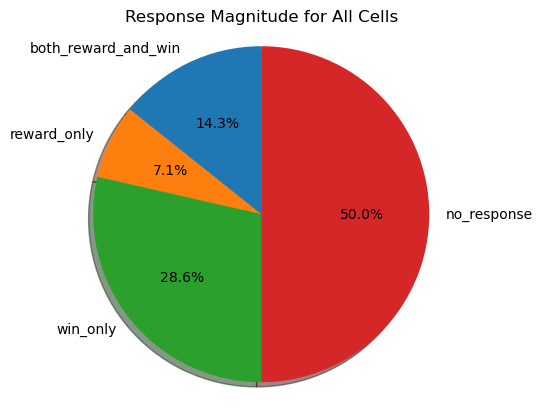

In [100]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

fig1, ax1 = plt.subplots()
ax1.pie(reward_or_win_firing_rate_difference_count.values(), labels=reward_or_win_firing_rate_difference_count.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Response Magnitude for All Cells")
plt.show()

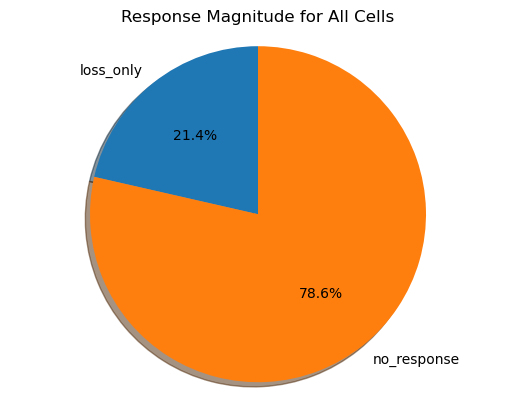

In [101]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

fig1, ax1 = plt.subplots()
ax1.pie(omission_or_loss_firing_rate_difference_count.values(), labels=omission_or_loss_firing_rate_difference_count.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Response Magnitude for All Cells")
plt.show()

# Looking at the firing rate for each 100ms time bin

## Seeing which 100ms bin each unit time belongs to

- Creating bins for each 100ms time interval

In [102]:
# Each bin's duration in seconds
bin_duration = 0.1

In [103]:
# Seeing how many bins are in the duration
# 0.1 is for 0.1 seconds or 100 miliseconds
bins_with_100ms_range = int(trial_one_way_duration / bin_duration)

In [104]:
bins_with_100ms_range

100

In [105]:
sampling_rate

20000

- Getting all the tone time bins before and after the tone

In [106]:
tone_unit_time_to_interval = {}
# Making a list of all the bins for each tone time stamp
for time in tone_time_stamps:
    tone_unit_time_to_interval[time] = [time + num * (bin_duration * sampling_rate) for num in range(bins_with_100ms_range * -1, bins_with_100ms_range)]

- The time bins for the first tone
    - Each time should be separated by an amount of the bin_duration * the sampling rate

In [107]:
tone_time_stamps[0]

1408048

In [108]:
tone_unit_time_to_interval[tone_time_stamps[0]][:5]

[1208048.0, 1210048.0, 1212048.0, 1214048.0, 1216048.0]

In [109]:
tone_unit_time_to_interval[tone_time_stamps[0]][-5:]

[1598048.0, 1600048.0, 1602048.0, 1604048.0, 1606048.0]

In [110]:
len(tone_unit_time_to_interval[tone_time_stamps[0]])

200

- Seeing which bin the tone time fits into

In [111]:
spike_column_name = "spike_time"

In [112]:
spike_tone_time_df = pd.DataFrame.from_dict(before_and_after_interval_unit_times, orient="index").reset_index().rename(columns={"index": spike_column_name})

In [113]:
spike_tone_time_df.head()

,spike_time,tone_time,before_or_after,neuron_id
0,1209073,1408048,before,64
1,1210306,1408048,before,54
2,1210810,1408048,before,174
3,1211041,1408048,before,52
4,1212118,1408048,before,54


In [114]:
all_tone_dataframes = []
for tone_time, bins_with_100ms in tone_unit_time_to_interval.items():
    # Filtering for all the rows with the current tone
    current_tone_df = spike_tone_time_df[spike_tone_time_df["tone_time"] == tone_time].copy()
    # Getting the time that each spike occured
    spike_time = current_tone_df[spike_column_name].values
    # Seeing which bin each spike fits into
    # Subtracting the number of bins so that you can get see where the spike is relative to tone time
    current_tone_df["bin_number"] = np.digitize(spike_time, tone_unit_time_to_interval[tone_time], right=True) - bins_with_100ms_range
    # Creating a list to concatenate all dataframes
    all_tone_dataframes.append(current_tone_df)

In [115]:
binned_spike_tone_time_df = pd.concat(all_tone_dataframes)

- Calculating how much time relative to the tone

In [116]:
binned_spike_tone_time_df["bin_time"] = binned_spike_tone_time_df["bin_number"] * bin_duration

In [117]:
binned_spike_tone_time_df.head()

,spike_time,tone_time,before_or_after,neuron_id,bin_number,bin_time
0,1209073,1408048,before,64,-99,-9.9
1,1210306,1408048,before,54,-98,-9.8
2,1210810,1408048,before,174,-98,-9.8
3,1211041,1408048,before,52,-98,-9.8
4,1212118,1408048,before,54,-97,-9.7


In [118]:
binned_spike_tone_time_df.tail()

,spike_time,tone_time,before_or_after,neuron_id,bin_number,bin_time
35950,61196610,60998563,after,183,100,10.0
35951,61196720,60998563,after,174,100,10.0
35952,61196875,60998563,after,174,100,10.0
35953,61197936,60998563,after,183,100,10.0
35954,61198104,60998563,after,183,100,10.0


## Calculating Firing Rate

- Getting the count of each neuron that fired during the tone interval grouped by the neuron's ID

In [119]:
binned_spike_fire_count_df = binned_spike_tone_time_df.drop(columns=["before_or_after", "bin_number"]).groupby(["tone_time", "bin_time", "neuron_id"]).count().unstack(fill_value=0).stack().reset_index().rename(columns={"spike_time": "fired_spike_count"})

In [120]:
binned_spike_fire_count_df.head()

,tone_time,bin_time,neuron_id,fired_spike_count
0,1408048,-9.9,16,0
1,1408048,-9.9,20,0
2,1408048,-9.9,24,0
3,1408048,-9.9,50,0
4,1408048,-9.9,52,0


In [121]:
binned_spike_fire_count_df.tail()

,tone_time,bin_time,neuron_id,fired_spike_count
92003,60998563,10.0,163,0
92004,60998563,10.0,174,2
92005,60998563,10.0,182,0
92006,60998563,10.0,183,3
92007,60998563,10.0,188,0


## Categorizing Rewarded vs Omitted for Training

In [122]:
binned_spike_fire_count_df["trial_type"] = binned_spike_fire_count_df["tone_time"].map(tone_timestamp_to_trial_type)

In [123]:
binned_spike_fire_count_df.head()

,tone_time,bin_time,neuron_id,fired_spike_count,trial_type
0,1408048,-9.9,16,0,rewarded
1,1408048,-9.9,20,0,rewarded
2,1408048,-9.9,24,0,rewarded
3,1408048,-9.9,50,0,rewarded
4,1408048,-9.9,52,0,rewarded


In [124]:
binned_spike_fire_count_df.tail()

,tone_time,bin_time,neuron_id,fired_spike_count,trial_type
92003,60998563,10.0,163,0,loss
92004,60998563,10.0,174,2,loss
92005,60998563,10.0,182,0,loss
92006,60998563,10.0,183,3,loss
92007,60998563,10.0,188,0,loss


## Calculate average firing rate for each neuron in each bin

- We will be averaging using the bin number, because we are curious about how the firing rate changes 10 seconds before and after at each 100ms bin(averaging across sessions)
    - And we will be averaging across trials that have the same trial type

- Neurons in rows
- Mean firing rate per bin

In [125]:
averaged_firing_rate_df = binned_spike_fire_count_df.drop(columns=["tone_time"]).groupby(['neuron_id', 'bin_time', 'trial_type']).mean().reset_index()

In [126]:
averaged_firing_rate_df

,neuron_id,bin_time,trial_type,fired_spike_count
0,16,-9.9,loss,0.000000
1,16,-9.9,omission,0.000000
2,16,-9.9,rewarded,0.090909
3,16,-9.9,win,0.000000
4,16,-9.8,loss,0.142857
...,...,...,...,...
11195,188,9.9,win,0.000000
11196,188,10.0,loss,0.000000
11197,188,10.0,omission,0.000000
11198,188,10.0,rewarded,0.090909


In [127]:
pivoted_averaged_firing_rate_df = averaged_firing_rate_df.pivot_table(values='fired_spike_count', columns=['bin_time', 'trial_type'], index=["neuron_id"])

In [128]:
pivoted_averaged_firing_rate_df.head()

bin_time       -9.9                                    -9.8             \
trial_type      loss  omission  rewarded       win      loss  omission   
neuron_id                                                                
16          0.000000  0.000000  0.090909  0.000000  0.142857  0.000000   
20          0.857143  0.000000  0.727273  0.500000  0.857143  0.666667   
24          0.571429  0.666667  0.727273  0.666667  0.571429  1.666667   
50          0.285714  0.000000  0.000000  0.083333  0.000000  0.000000   
52          0.000000  0.000000  0.181818  0.083333  0.000000  0.333333   

bin_time                           -9.7             ...      9.8             \
trial_type  rewarded       win      loss  omission  ...  rewarded       win   
neuron_id                                           ...                       
16          0.000000  0.000000  0.285714  0.000000  ...  0.181818  0.416667   
20          0.272727  1.000000  0.571429  0.333333  ...  1.363636  0.916667   
24          0.727273  0.916667  0.285714  1.333333  ...  0.454545  0.916667   
50          0.000000  0.500000  0.142857  0.000000  ...  0.181818  0.083333   
52          0.181818  0.000000  0.142857  0.000000  ...  0.090909  0.083333   

bin_time        9.9                                     10.0            \
trial_type      loss  omission  rewarded       win      loss  omission   
neuron_id                                                                
16          0.000000  0.000000  0.000000  0.416667  0.000000  0.000000   
20          0.857143  1.333333  0.909091  1.166667  0.571429  0.333333   
24          0.857143  0.666667  0.363636  1.333333  0.714286  0.666667   
50          0.428571  0.000000  0.181818  0.083333  0.142857  0.000000   
52          0.142857  0.000000  0.272727  0.000000  0.285714  0.000000   

bin_time                        
trial_type  rewarded       win  
neuron_id                       
16          0.090909  0.166667  
20          1.454545  1.333333  
24          0.636364  1.250000  
50          0.090909  0.000000  
52          0.090909  0.083333  

[5 rows x 800 columns]

- Removing all the columns that don't have firing rate info
    - AKA the index and the tone time

In [129]:
resetted_averaged_firing_rate_array = pivoted_averaged_firing_rate_df.values

In [130]:
resetted_averaged_firing_rate_array[:5]

array([[0.        , 0.        , 0.09090909, ..., 0.        , 0.09090909,
        0.16666667],
       [0.85714286, 0.        , 0.72727273, ..., 0.33333333, 1.45454545,
        1.33333333],
       [0.57142857, 0.66666667, 0.72727273, ..., 0.66666667, 0.63636364,
        1.25      ],
       [0.28571429, 0.        , 0.        , ..., 0.        , 0.09090909,
        0.        ],
       [0.        , 0.        , 0.18181818, ..., 0.        , 0.09090909,
        0.08333333]])

# PCA with Neuron Rows

## Standarizing the Data

In [131]:
from sklearn.preprocessing import StandardScaler

In [132]:
# Separating out the features
x = resetted_averaged_firing_rate_array#.loc[:].values# Separating out the target
resetted_averaged_firing_rate_array = StandardScaler().fit_transform(x)

## Calculating the PCA

In [133]:
from sklearn.decomposition import PCA


- Getting the PC Coeffecients

In [134]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(resetted_averaged_firing_rate_array)
principal_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [135]:
principal_df.head()

,principal component 1,principal component 2
0,-17.093090,0.453367
1,19.273020,-15.576575
2,8.643789,-1.499456
3,-16.781126,-1.381385
4,-15.113296,-1.362618


In [136]:
principal_df["principal component 1"]

0    -17.093090
1     19.273020
2      8.643789
3    -16.781126
4    -15.113296
5     18.103345
6     -9.344594
7     -8.957818
8    -17.873680
9    -13.005320
10    61.053241
11   -20.443387
12    30.787193
13   -19.248277
Name: principal component 1, dtype: float64

In [137]:
pc1_product = pivoted_averaged_firing_rate_df.reset_index(drop=True).multiply(principal_df["principal component 1"], axis="index")

In [138]:
pc1_product

bin_time        -9.9                                          -9.8   \
trial_type       loss    omission   rewarded         win       loss   
0           -0.000000   -0.000000  -1.553917   -0.000000  -2.441870   
1           16.519732    0.000000  14.016742    9.636510  16.519732   
2            4.939308    5.762526   6.286392    5.762526   4.939308   
3           -4.794607   -0.000000  -0.000000   -1.398427  -0.000000   
4           -0.000000   -0.000000  -2.747872   -1.259441  -0.000000   
5           23.275730   36.206691  14.811828   18.103345  20.689538   
6           -4.004826   -6.229729  -1.699017   -3.114865  -1.334942   
7           -2.559377   -2.985939  -4.071736   -1.492970  -3.839065   
8           -0.000000   -5.957893  -3.249760   -0.000000  -0.000000   
9           -0.000000   -0.000000  -0.000000   -3.251330  -1.857903   
10          87.218915  101.755401  66.603535  111.930941  69.775132   
11          -2.920484   -0.000000  -0.000000   -1.703616  -0.000000   
12          13.194511   30.787193  25.189521   23.090395  30.787193   
13          -2.749754   -6.416092  -1.749843   -0.000000  -0.000000   

bin_time                                          -9.7              ...  \
trial_type   omission   rewarded         win       loss   omission  ...   
0           -0.000000  -0.000000   -0.000000  -4.883740  -0.000000  ...   
1           12.848680   5.256278   19.273020  11.013155   6.424340  ...   
2           14.406315   6.286392    7.923473   2.469654  11.525052  ...   
3           -0.000000  -0.000000   -8.390563  -2.397304  -0.000000  ...   
4           -5.037765  -2.747872   -0.000000  -2.159042  -0.000000  ...   
5            6.034448  24.686380   13.577509  12.930961  18.103345  ...   
6           -3.114865  -1.699017   -2.336148  -4.004826  -0.000000  ...   
7           -2.985939  -2.443041   -2.239455  -3.839065  -2.985939  ...   
8           -5.957893  -0.000000   -1.489473  -0.000000  -0.000000  ...   
9           -0.000000  -2.364604   -6.502660  -3.715806  -0.000000  ...   
10          40.702160  72.153830  137.369792  52.331349  61.053241  ...   
11          -0.000000  -0.000000   -0.000000  -0.000000 -13.628924  ...   
12          71.836783  13.994179   25.655994  39.583534  10.262398  ...   
13          -6.416092  -5.249530   -0.000000  -0.000000  -0.000000  ...   

bin_time          9.8                    9.9                          \
trial_type    rewarded         win       loss    omission   rewarded   
0            -3.107835   -7.122121  -0.000000   -0.000000  -0.000000   
1            26.281392   17.666935  16.519732   25.697361  17.520928   
2             3.928995    7.923473   7.408962    5.762526   3.143196   
3            -3.051114   -1.398427  -7.191911   -0.000000  -3.051114   
4            -1.373936   -1.259441  -2.159042   -0.000000  -4.121808   
5             6.583035   10.560285  12.930961   12.068897   8.228793   
6            -1.699017   -2.336148  -2.669884   -6.229729  -0.849509   
7            -2.443041   -0.746485  -0.000000   -2.985939  -6.514777   
8            -1.624880   -2.978947  -0.000000   -0.000000  -0.000000   
9            -2.364604   -1.083777  -0.000000   -4.335107  -2.364604   
10          116.556187  111.930941  52.331349  101.755401  77.704125   
11           -1.858490   -0.000000  -2.920484   -0.000000  -0.000000   
12           13.994179   30.787193  21.990852   51.311988  50.379043   
13           -0.000000   -1.604023  -2.749754   -0.000000  -1.749843   

bin_time                     10.0                                      
trial_type         win       loss    omission    rewarded         win  
0            -7.122121  -0.000000   -0.000000   -1.553917   -2.848848  
1            22.485191  11.013155    6.424340   28.033484   25.697361  
2            11.525052   6.174135    5.762526    5.500593   10.804736  
3            -1.398427  -2.397304   -0.000000   -1.525557   -0.000000  
4            -0.000000  -4.318085   -0.000000   -1.373936   -1.259441  
5    

In [139]:
pc1_product.mean()

bin_time  trial_type
-9.9      loss           9.151368
          omission      10.923011
          rewarded       7.988277
          win           11.164505
-9.8      loss           9.516937
                          ...    
 9.9      win           13.470709
 10.0     loss           8.932381
          omission      10.533952
          rewarded      11.871625
          win           13.431763
Length: 800, dtype: float64

In [140]:
pc2_product = pivoted_averaged_firing_rate_df.reset_index(drop=True).multiply(principal_df["principal component 2"], axis="index")

In [141]:
pc2_product

bin_time        -9.9                                        -9.8              \
trial_type       loss   omission   rewarded        win       loss   omission   
0            0.000000   0.000000   0.041215   0.000000   0.064767   0.000000   
1          -13.351350  -0.000000 -11.328418  -7.788288 -13.351350 -10.384384   
2           -0.856832  -0.999638  -1.090514  -0.999638  -0.856832  -2.499094   
3           -0.394681  -0.000000  -0.000000  -0.115115  -0.000000  -0.000000   
4           -0.000000  -0.000000  -0.247749  -0.113551  -0.000000  -0.454206   
5           26.037608  40.502946  16.569387  20.251473  23.144540   6.750491   
6            0.507385   0.789265   0.215254   0.394633   0.169128   0.394633   
7           -0.111566  -0.130161  -0.177492  -0.065080  -0.167350  -0.130161   
8           -0.000000  -0.284466  -0.155163  -0.000000  -0.000000  -0.284466   
9           -0.000000  -0.000000  -0.000000  -1.249069  -0.713753  -0.000000   
10         -18.732753 -21.854879 -14.305012 -24.040367 -14.986203  -8.741952   
11          -0.173022  -0.000000  -0.000000  -0.100930  -0.000000  -0.000000   
12           8.305747  19.380077  15.856426  14.535058  19.380077  45.220179   
13          -0.126363  -0.294847  -0.080413  -0.000000  -0.000000  -0.294847   

bin_time                              -9.7              ...       9.8   \
trial_type   rewarded        win       loss   omission  ...   rewarded   
0            0.000000   0.000000   0.129533   0.000000  ...   0.082430   
1           -4.248157 -15.576575  -8.900900  -5.192192  ... -21.240785   
2           -1.090514  -1.374502  -0.428416  -1.999275  ...  -0.681571   
3           -0.000000  -0.690693  -0.197341  -0.000000  ...  -0.251161   
4           -0.247749  -0.000000  -0.194660  -0.000000  ...  -0.123874   
5           27.615645  15.188605  14.465338  20.251473  ...   7.364172   
6            0.215254   0.295974   0.507385   0.000000  ...   0.215254   
7           -0.106495  -0.097621  -0.167350  -0.130161  ...  -0.106495   
8           -0.000000  -0.071117  -0.000000  -0.000000  ...  -0.077582   
9           -0.908413  -2.498137  -1.427507  -0.000000  ...  -0.908413   
10         -15.497096 -29.504086 -11.239652 -13.112927  ... -25.033770   
11          -0.000000  -0.000000  -0.000000  -0.807438  ...  -0.110105   
12           8.809126  16.150064  24.917242   6.460026  ...   8.809126   
13          -0.241238  -0.000000  -0.000000  -0.000000  ...  -0.000000   

bin_time                    9.9                                         10.0  \
trial_type        win       loss   omission   rewarded        win       loss   
0            0.188903   0.000000   0.000000   0.000000   0.188903   0.000000   
1          -14.278527 -13.351350 -20.768767 -14.160523 -18.172671  -8.900900   
2           -1.374502  -1.285248  -0.999638  -0.545257  -1.999275  -1.071040   
3           -0.115115  -0.592022  -0.000000  -0.251161  -0.115115  -0.197341   
4           -0.113551  -0.194660  -0.000000  -0.371623  -0.000000  -0.389319   
5           11.813359  14.465338  13.500982   9.205215   8.438114  14.465338   
6            0.295974   0.338257   0.789265   0.107627   0.098658   0.338257   
7           -0.032540  -0.000000  -0.130161  -0.283987  -0.195241  -0.111566   
8           -0.142233  -0.000000  -0.000000  -0.000000  -0.000000  -0.121914   
9           -0.416356  -0.000000  -1.665425  -0.908413  -0.832712  -0.000000   
10         -24.040367 -11.239652 -21.854879 -16.689180 -30.596830 -13.112927   
11          -0.000000  -0.173022  -0.000000  -0.000000  -0.000000  -0.000000   
12          19.380077  13.842912  32.300128  31.712853  12.920051  30.454406   
13          -0.073712  -0.126363  -0.000000  -0.080413  -0.000000  -0.000000   

bin_time                                     
trial_type   omission   rewarded        win  
0            0.000000   0.041215   0.075561  
1           -5.192192 -22.656837 -20.768767  
2           -0.999638  -0.954199  -1.874320  
3           -0.000000  

In [142]:
pc2_product.mean()

bin_time  trial_type
-9.9      loss          0.078869
          omission      2.650593
          rewarded      0.378394
          win           0.050652
-9.8      loss          0.905930
                          ...   
 9.9      win          -2.161866
 10.0     loss          1.525214
          omission     -1.343752
          rewarded     -1.090872
          win          -1.114096
Length: 800, dtype: float64

In [143]:
pc_product = pd.concat([pc1_product.mean(), pc2_product.mean()], axis=1)#.reset_index()

In [144]:
pc_product.head()

0         1
bin_time trial_type                     
-9.9     loss         9.151368  0.078869
         omission    10.923011  2.650593
         rewarded     7.988277  0.378394
         win         11.164505  0.050652
-9.8     loss         9.516937  0.905930

In [145]:
pc_product = pc_product.reset_index()

In [146]:
pc_product.head()

,bin_time,trial_type,0,1
0,-9.9,loss,9.151368,0.078869
1,-9.9,omission,10.923011,2.650593
2,-9.9,rewarded,7.988277,0.378394
3,-9.9,win,11.164505,0.050652
4,-9.8,loss,9.516937,0.905930


In [147]:
def get_before_during_after(x):
    if -10 <= x < -5:
        return "-10s to 5s"
    elif -5 <= x < 0:
        return "-5s to 0s"
    elif 0 <= x < 5:
        return "0s to 5s"
    elif 5 <= x <= 10:
        return "5s to 10s"
    else:
        return np.nan

In [148]:
pc_product["before_during_after"] = pc_product["bin_time"].apply(lambda x: get_before_during_after(x))

In [149]:
pc_product.head()

,bin_time,trial_type,0,1,before_during_after
0,-9.9,loss,9.151368,0.078869,-10s to 5s
1,-9.9,omission,10.923011,2.650593,-10s to 5s
2,-9.9,rewarded,7.988277,0.378394,-10s to 5s
3,-9.9,win,11.164505,0.050652,-10s to 5s
4,-9.8,loss,9.516937,0.905930,-10s to 5s


In [150]:
pc_product["outcome_and_when"] = pc_product.apply(lambda x: x["before_during_after"] + " " + x["trial_type"], axis=1)

In [151]:
pc_product.head()

,bin_time,trial_type,0,1,before_during_after,outcome_and_when
0,-9.9,loss,9.151368,0.078869,-10s to 5s,-10s to 5s loss
1,-9.9,omission,10.923011,2.650593,-10s to 5s,-10s to 5s omission
2,-9.9,rewarded,7.988277,0.378394,-10s to 5s,-10s to 5s rewarded
3,-9.9,win,11.164505,0.050652,-10s to 5s,-10s to 5s win
4,-9.8,loss,9.516937,0.905930,-10s to 5s,-10s to 5s loss


- Getting only rows from -5 to 5 seconds

In [152]:
pc_product = pc_product[pc_product["bin_time"] >= -5]

In [153]:
omission_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "omission" in name]
rewarded_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "rewarded" in name]
win_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "win" in name]
loss_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "loss" in name]


In [284]:
pc_product

,bin_time,trial_type,0,1,before_during_after,outcome_and_when
196,-5.0,loss,5.918772,2.101570,-5s to 0s,-5s to 0s loss
197,-5.0,omission,9.144388,-0.691394,-5s to 0s,-5s to 0s omission
198,-5.0,rewarded,5.172542,0.717963,-5s to 0s,-5s to 0s rewarded
199,-5.0,win,10.610293,-0.431691,-5s to 0s,-5s to 0s win
200,-4.9,loss,5.708605,1.986960,-5s to 0s,-5s to 0s loss
...,...,...,...,...,...,...
795,9.9,win,13.470709,-2.161866,5s to 10s,5s to 10s win
796,10.0,loss,8.932381,1.525214,5s to 10s,5s to 10s loss
797,10.0,omission,10.533952,-1.343752,5s to 10s,5s to 10s omission
798,10.0,rewarded,11.871625,-1.090872,5s to 10s,5s to 10s rewarded


In [154]:
omission_pc = pc_product[pc_product["trial_type"] == "omission"]

In [155]:
omission_pc

,bin_time,trial_type,0,1,before_during_after,outcome_and_when
197,-5.0,omission,9.144388,-0.691394,-5s to 0s,-5s to 0s omission
201,-4.9,omission,7.355291,-1.299552,-5s to 0s,-5s to 0s omission
205,-4.8,omission,11.679792,-1.985883,-5s to 0s,-5s to 0s omission
209,-4.7,omission,13.180058,-1.535288,-5s to 0s,-5s to 0s omission
213,-4.6,omission,6.181651,-0.835630,-5s to 0s,-5s to 0s omission
...,...,...,...,...,...,...
781,9.6,omission,10.442052,-0.989831,5s to 10s,5s to 10s omission
785,9.7,omission,8.114117,-0.036710,5s to 10s,5s to 10s omission
789,9.8,omission,10.635356,-2.229920,5s to 10s,5s to 10s omission
793,9.9,omission,13.074671,0.083679,5s to 10s,5s to 10s omission


In [156]:
averaged_omission_pc = omission_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()

/tmp/ipykernel_3244569/866166829.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged_omission_pc = omission_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()


In [157]:
averaged_omission_pc

,index,bin_time,0,1
0,0,-4.9,9.393157,-1.325610
1,1,-4.6,10.445121,-1.120090
2,2,-4.3,12.094184,-3.333807
3,3,-4.0,12.774975,-2.254244
4,4,-3.7,9.986333,-0.847047
5,5,-3.4,14.199975,-1.530809
6,6,-3.1,13.263002,0.602622
7,7,-2.8,9.813694,-0.403137
8,8,-2.5,10.952766,-1.982505
9,9,-2.2,8.165035,-0.841431


In [158]:
rewarded_pc = pc_product[pc_product["trial_type"] == "rewarded"]

In [159]:
averaged_rewarded_pc = rewarded_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()

/tmp/ipykernel_3244569/1841766349.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged_rewarded_pc = rewarded_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()


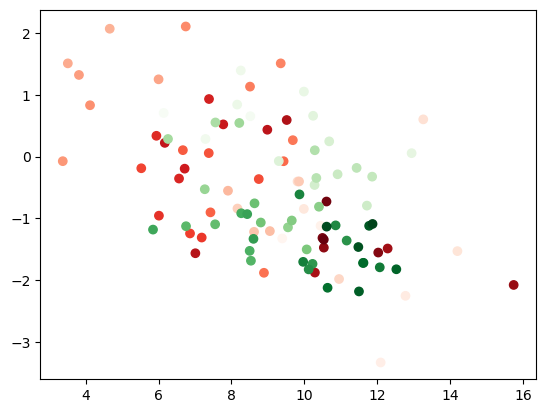

In [160]:
plt.scatter(averaged_omission_pc[0], averaged_omission_pc[1], c=averaged_omission_pc["index"], cmap='Reds')
plt.scatter(averaged_rewarded_pc[0], averaged_rewarded_pc[1], c=averaged_rewarded_pc["index"], cmap='Greens')

plt.show()

In [161]:
all_categories = sorted(pc_product["outcome_and_when"].unique())

In [162]:
all_categories = [category for category in all_categories if not "-10" in category]

In [163]:
all_categories

['-5s to 0s loss',
 '-5s to 0s omission',
 '-5s to 0s rewarded',
 '-5s to 0s win',
 '0s to 5s loss',
 '0s to 5s omission',
 '0s to 5s rewarded',
 '0s to 5s win',
 '5s to 10s loss',
 '5s to 10s omission',
 '5s to 10s rewarded',
 '5s to 10s win']

win: blue
loss: yellow
rewarded: green
omission: red

In [164]:
all_colors = ["gold", "pink", "lightgreen", "lightblue", "orange", "red", "green", "cyan", "darkorange", "darkred", "darkgreen", "darkcyan"]


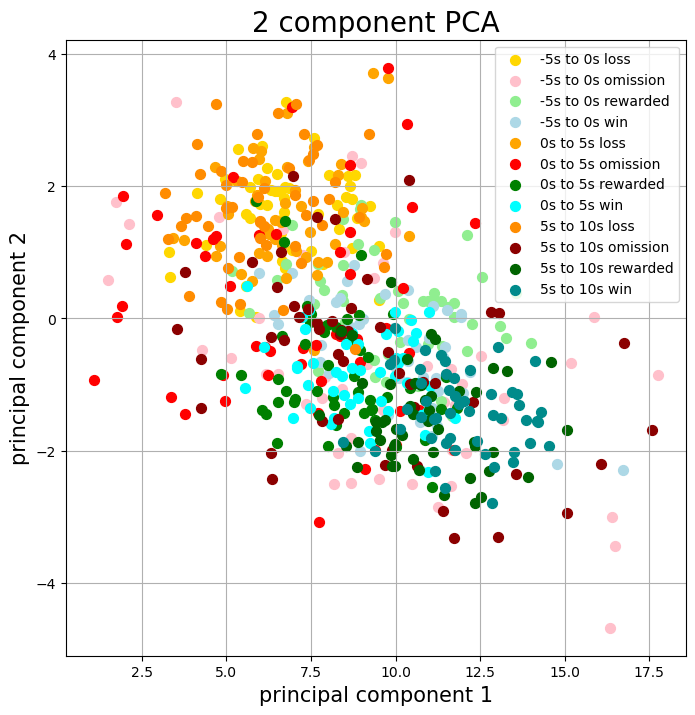

In [165]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = rewarded_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(all_categories, all_colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(all_categories)
ax.grid()

## Looking at each plot individually across time

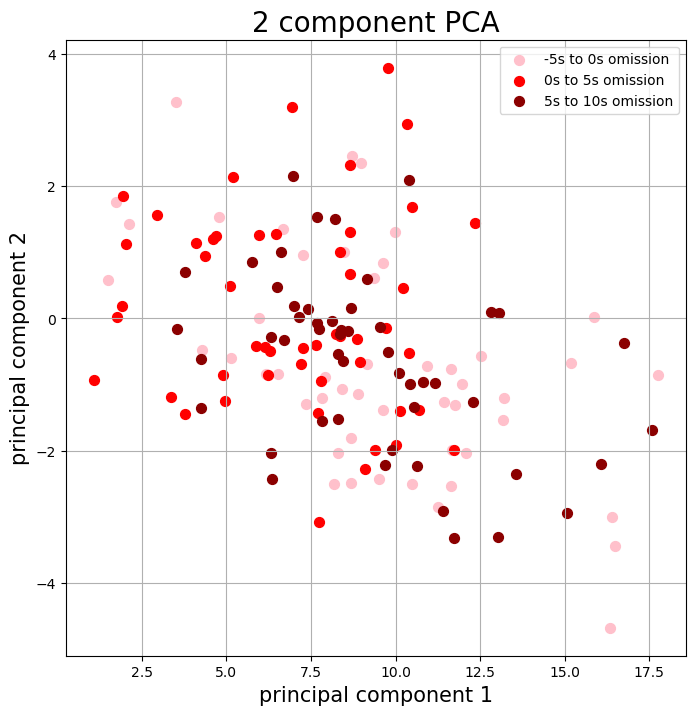

In [166]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["pink", "red", "darkred"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

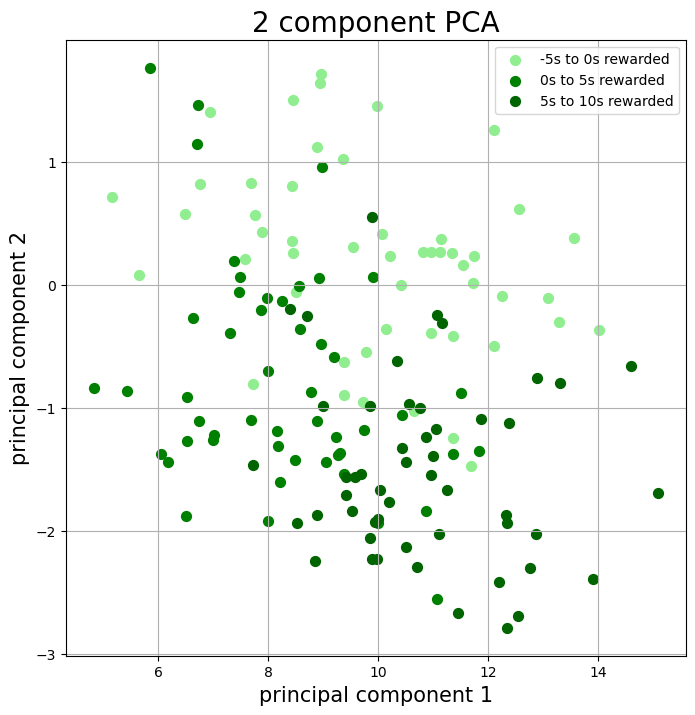

In [167]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = rewarded_categories
colors = ["lightgreen", "green", "darkgreen"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

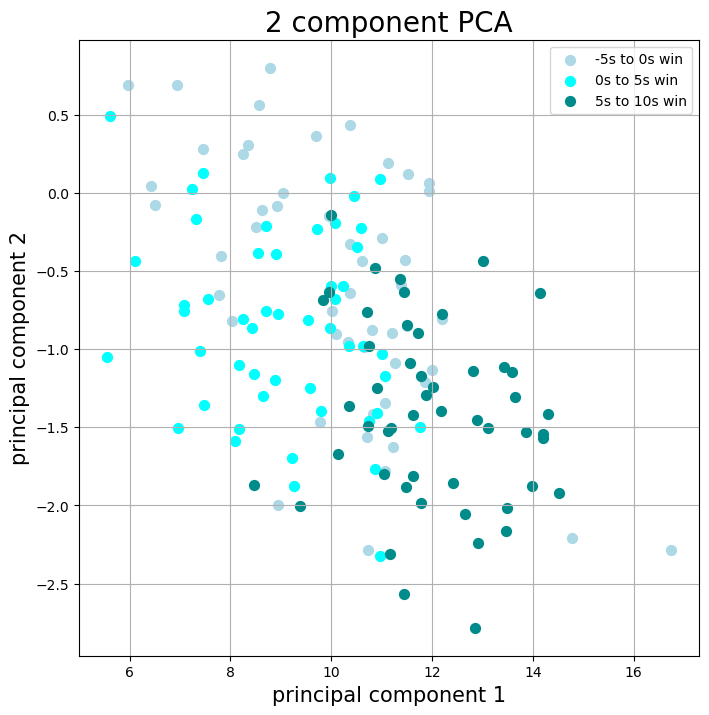

In [168]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = win_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

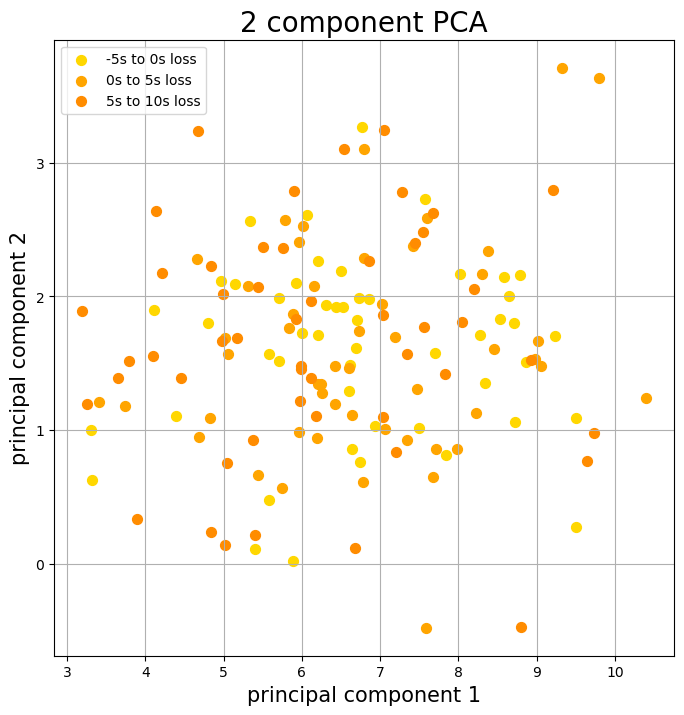

In [169]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = loss_categories
colors = ["gold", "orange", "darkorange"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

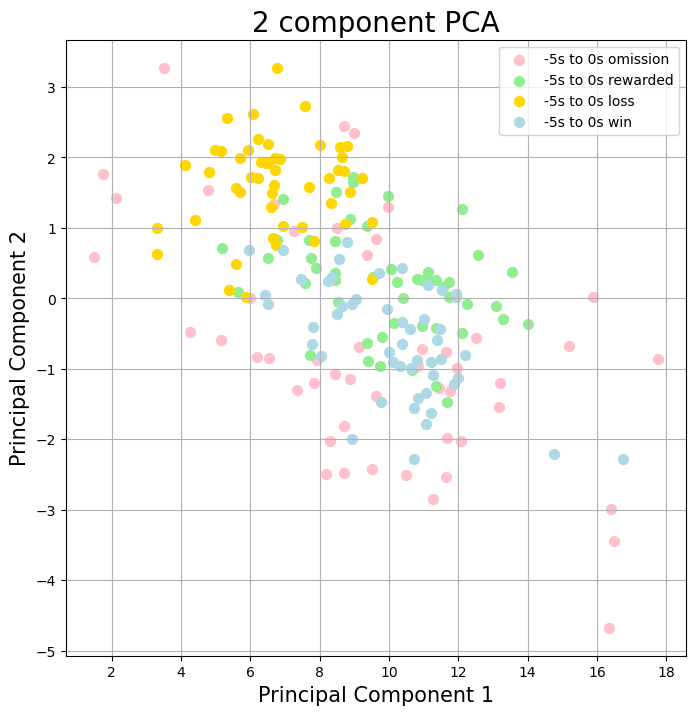

In [174]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['-5s to 0s omission', '-5s to 0s rewarded', '-5s to 0s loss', '-5s to 0s win']
colors = ["pink", "lightgreen", "gold", "lightblue"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

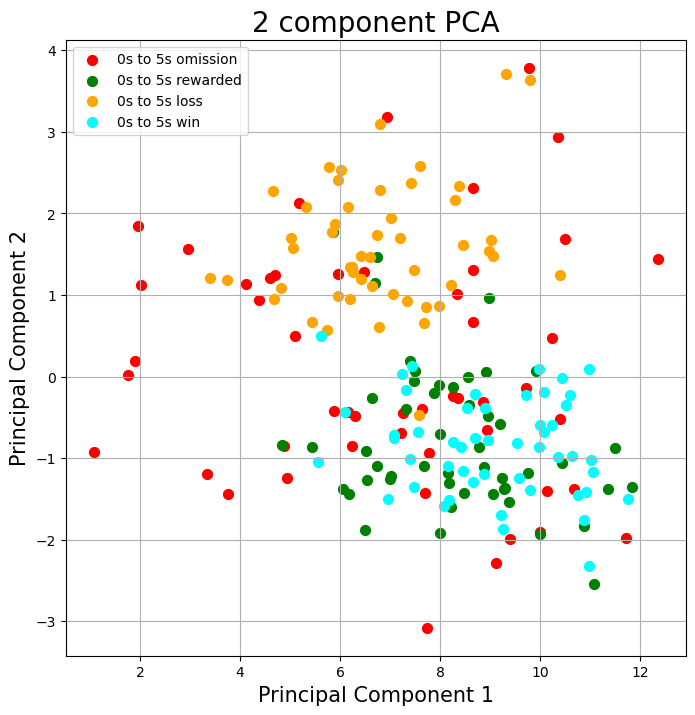

In [175]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0s to 5s omission', '0s to 5s rewarded', '0s to 5s loss', '0s to 5s win']
colors = ["red", "green", "orange", "cyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

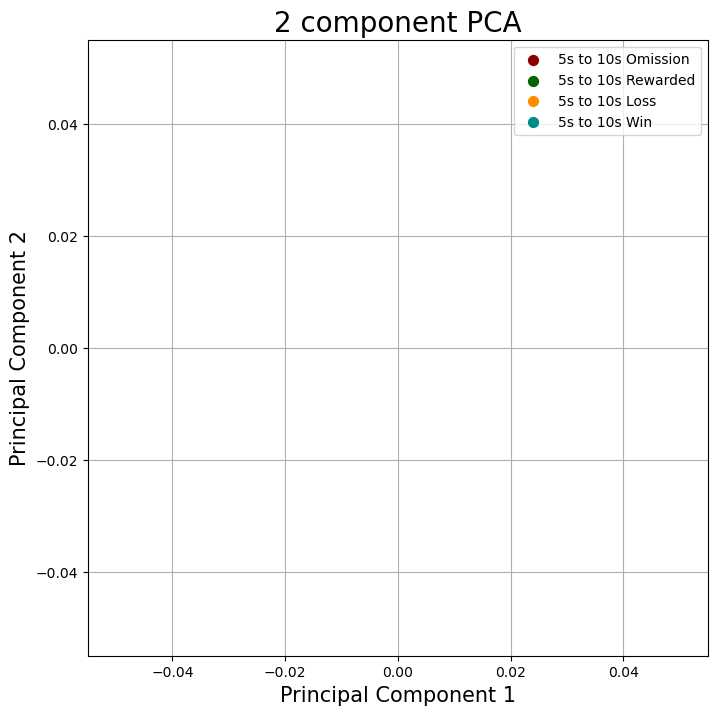

In [172]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['5s to 10s Omission', '5s to 10s Rewarded', '5s to 10s Loss', '5s to 10s Win']
colors = ["darkred", "darkgreen", "darkorange", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()